In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering and evaluation imports
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score,
    normalized_mutual_info_score, pairwise_distances,
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Data loaded. Shape: (14768, 29)
Missing values filled.
Binary label CO2_Class created.
Features scaled.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1524\1529930442.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CO2 Emissions(g/km)'].fillna(df['CO2 Emissions(g/km)'].mean(), inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1524\1529930442.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

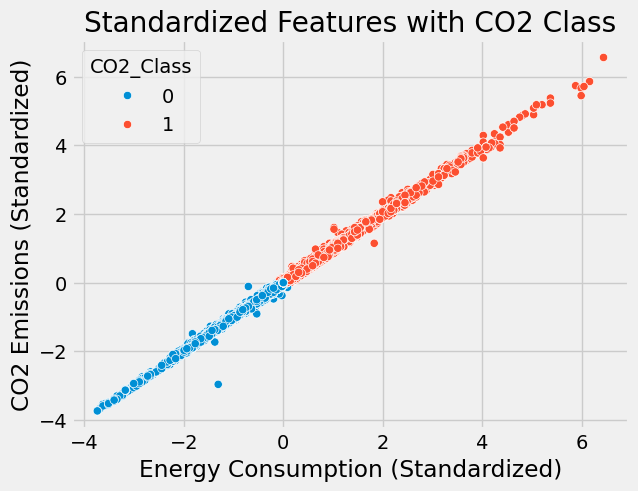

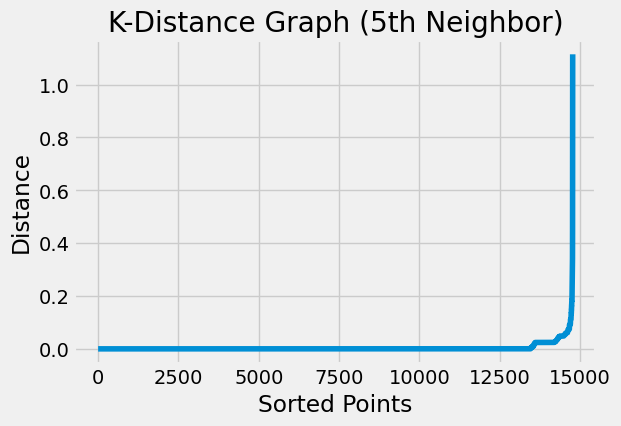

Suggested eps from k-distance graph: 0.7551578833343088
DBSCAN finished. Number of clusters: 18


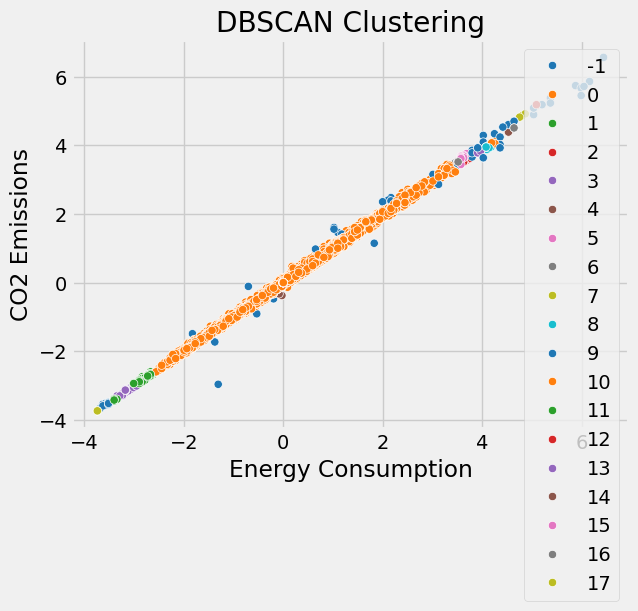

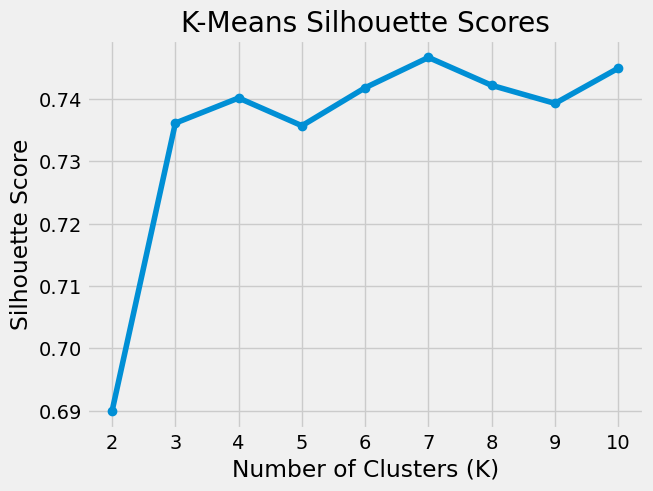

Optimal K for K-Means: 7


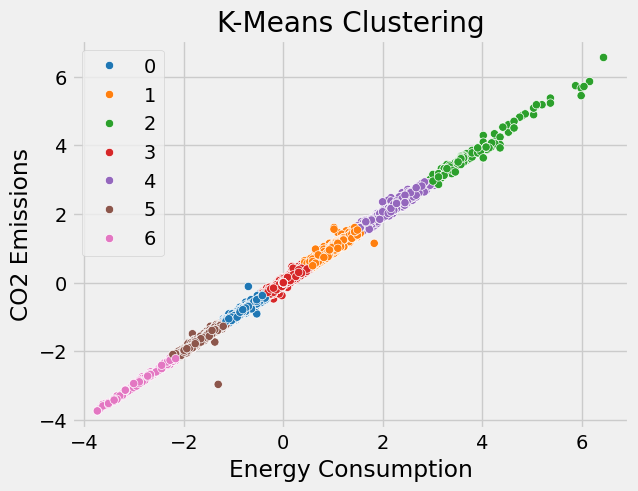

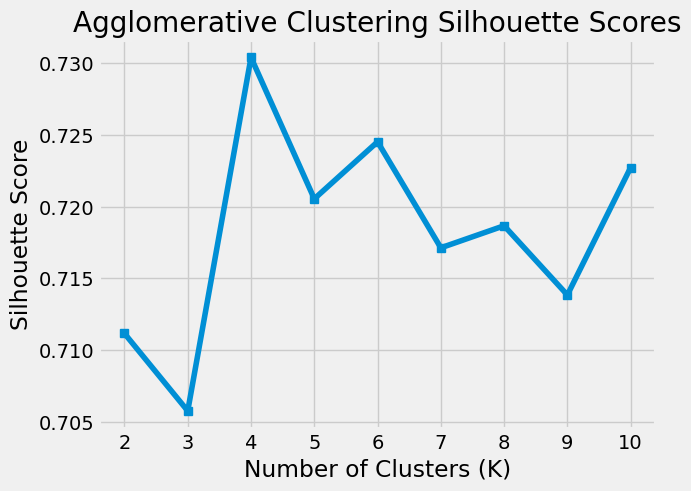

Optimal K for Agglomerative Clustering: 4


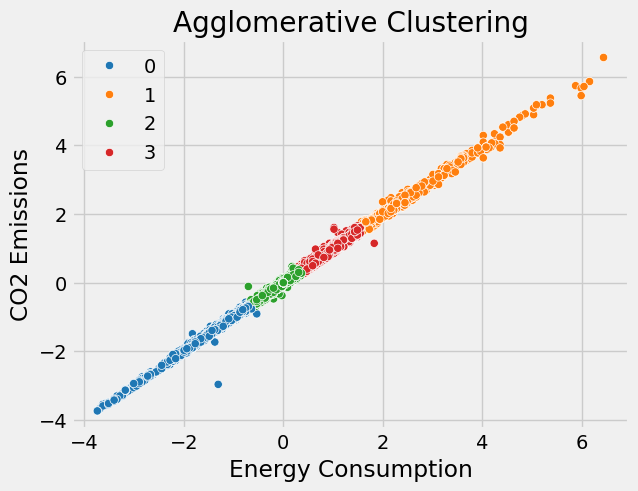


Evaluation Results:
           Model       ARI       NMI  Cosine_Sim
0  Agglomerative  0.411414  0.470142    0.823402
1        K-Means  0.289182  0.369791    0.891928
2         DBSCAN  0.028919  0.043333    0.010631

Best model based on ARI, NMI, and Cosine Similarity: Agglomerative

Final results saved to 'Clustering_Evaluation_Result.csv'.


In [ ]:

# 1) Read data
train_file = r"Dataset2_train.csv"
test_file = r"Dataset2_test.csv"
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)
df = pd.concat([df_train, df_test], ignore_index=True)
print("Data loaded. Shape:", df.shape)

# 2) Clean missing values
df['CO2 Emissions(g/km)'].fillna(df['CO2 Emissions(g/km)'].mean(), inplace=True)
df['Energy Consumption per Distance MJ/100km'].fillna(
    df['Energy Consumption per Distance MJ/100km'].mean(), inplace=True
)
print("Missing values filled.")

# Create binary label for evaluation
median_co2 = df['CO2 Emissions(g/km)'].median()
df['CO2_Class'] = (df['CO2 Emissions(g/km)'] > median_co2).astype(int)
print("Binary label CO2_Class created.")

# 3) Select features and standardize
X = df[['Energy Consumption per Distance MJ/100km', 'CO2 Emissions(g/km)']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled.")

# Visualize features
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['CO2_Class'])
plt.title("Standardized Features with CO2 Class")
plt.xlabel("Energy Consumption (Standardized)")
plt.ylabel("CO2 Emissions (Standardized)")
plt.grid(True)
plt.show()

# 4) Plot k-distance graph for DBSCAN
neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(X_scaled)
distances, _ = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.title("K-Distance Graph (5th Neighbor)")
plt.xlabel("Sorted Points")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

eps_candidate = distances[np.argmax(np.diff(distances))]
print("Suggested eps from k-distance graph:", eps_candidate)

# 5) DBSCAN
dbscan = DBSCAN(eps=0.08, min_samples=4)
dbscan_labels = dbscan.fit_predict(X_scaled)
df['DBSCAN_Cluster'] = dbscan_labels
print("DBSCAN finished. Number of clusters:", len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0))

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=dbscan_labels, palette='tab10')
plt.title("DBSCAN Clustering")
plt.xlabel("Energy Consumption")
plt.ylabel("CO2 Emissions")
plt.grid(True)
plt.show()

# 6) K-Means with silhouette scores
k_values = range(2, 11)
kmeans_sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    kmeans_sil_scores.append(sil)

plt.plot(k_values, kmeans_sil_scores, marker='o')
plt.title("K-Means Silhouette Scores")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

optimal_k = k_values[np.argmax(kmeans_sil_scores)]
print("Optimal K for K-Means:", optimal_k)

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['KMeans_Cluster'] = kmeans_labels

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='tab10')
plt.title("K-Means Clustering")
plt.xlabel("Energy Consumption")
plt.ylabel("CO2 Emissions")
plt.grid(True)
plt.show()

# 7) Agglomerative Clustering
agg_sil_scores = []
for k in k_values:
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    agg_sil_scores.append(sil)

plt.plot(k_values, agg_sil_scores, marker='s')
plt.title("Agglomerative Clustering Silhouette Scores")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

optimal_k_agg = k_values[np.argmax(agg_sil_scores)]
print("Optimal K for Agglomerative Clustering:", optimal_k_agg)

agg_model = AgglomerativeClustering(n_clusters=optimal_k_agg)
agg_labels = agg_model.fit_predict(X_scaled)
df['Agglomerative_Cluster'] = agg_labels

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=agg_labels, palette='tab10')
plt.title("Agglomerative Clustering")
plt.xlabel("Energy Consumption")
plt.ylabel("CO2 Emissions")
plt.grid(True)
plt.show()

# 8) Evaluation function
def evaluate_model(true_binary, predicted_cluster):
    ari = adjusted_rand_score(true_binary, predicted_cluster)
    nmi = normalized_mutual_info_score(true_binary, predicted_cluster)
    true_vals = df[['CO2 Emissions(g/km)']].values.reshape(-1, 1)
    pred_vals = predicted_cluster.reshape(-1, 1)
    cos_sim = 1 - pairwise_distances(true_vals, pred_vals, metric='cosine').mean()
    return ari, nmi, cos_sim

dbscan_ari, dbscan_nmi, dbscan_cos = evaluate_model(df['CO2_Class'], dbscan_labels)
kmeans_ari, kmeans_nmi, kmeans_cos = evaluate_model(df['CO2_Class'], kmeans_labels)
agg_ari, agg_nmi, agg_cos = evaluate_model(df['CO2_Class'], agg_labels)

results = pd.DataFrame({
    'Model': ['DBSCAN', 'K-Means', 'Agglomerative'],
    'ARI': [dbscan_ari, kmeans_ari, agg_ari],
    'NMI': [dbscan_nmi, kmeans_nmi, agg_nmi],
    'Cosine_Sim': [dbscan_cos, kmeans_cos, agg_cos]
})

results_sorted = results.sort_values(
    by=['ARI', 'NMI', 'Cosine_Sim'], ascending=False
).reset_index(drop=True)

print("\nEvaluation Results:")
print(results_sorted)

best_model = results_sorted.loc[0, 'Model']
print("\nBest model based on ARI, NMI, and Cosine Similarity:", best_model)

# 9) Save to CSV
out_file = r"Clustering_Evaluation_Result.csv"
df.to_csv(out_file, index=False)
print(f"\nFinal results saved to '{out_file}'.")

In [28]:
# 10) Logistic Regression to predict best cluster label
# Now the cluster is target, and full features are inputs
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

cluster_column = best_model + '_Cluster'

filtered_df = pd.read_csv(out_file)

# Remove noise for DBSCAN
#filtered_df = df[df[cluster_column] != -1].copy()

# Use the provided feature list
feature_cols = [
    'Engine Size(L)', 'Cylinders', 'Gearbox_Type', 'Gearbox_Number',
    'Energy Consumption per Distance MJ/100km',
    'Model Features_Flexible-fuel vehicle', 'Model Features_Four-wheel drive',
    'Model Features_Long wheelbase', 'Model Features_Short wheelbase',
    'Vehicle Class_FULL-SIZE', 'Vehicle Class_MID-SIZE', 'Vehicle Class_MINICOMPACT',
    'Vehicle Class_MINIVAN', 'Vehicle Class_PICKUP TRUCK - SMALL',
    'Vehicle Class_PICKUP TRUCK - STANDARD', 'Vehicle Class_SPECIAL PURPOSE VEHICLE',
    'Vehicle Class_STATION WAGON - MID-SIZE', 'Vehicle Class_STATION WAGON - SMALL',
    'Vehicle Class_SUBCOMPACT', 'Vehicle Class_SUV - SMALL', 'Vehicle Class_SUV - STANDARD',
    'Vehicle Class_TWO-SEATER', 'Vehicle Class_VAN - CARGO', 'Vehicle Class_VAN - PASSENGER',
    'Fuel Type_E', 'Fuel Type_X', 'Fuel Type_Z'
]

X = filtered_df[feature_cols]
y = filtered_df[cluster_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)

# Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title(f'Confusion Matrix: {best_model} Clusters')
plt.grid(False)
plt.show()

# ROC Curve
plt.figure()
if len(np.unique(y)) > 2:
    for i in range(model.classes_.shape[0]):
        fpr, tpr, _ = roc_curve((y_test == model.classes_[i]).astype(int), y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {model.classes_[i]} AUC = {roc_auc:.2f}')
else:
    fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Predicting {best_model} Clusters')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [29]:
X

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Energy Consumption per Distance MJ/100km,Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,Model Features_Long wheelbase,Model Features_Short wheelbase,Vehicle Class_FULL-SIZE,...,Vehicle Class_STATION WAGON - SMALL,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,4.0,6.0,1.0,5.0,434.340000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.4,4.0,1.0,6.0,287.280000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,4.0,1.0,8.0,321.480000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.5,4.0,1.0,6.0,307.800000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,8.0,1.0,8.0,454.860000,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14763,NaN,NaN,NaN,NaN,367.642874,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14764,NaN,NaN,NaN,NaN,367.642874,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14765,NaN,NaN,NaN,NaN,367.642874,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14766,NaN,NaN,NaN,NaN,367.642874,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
